## Imports and Loading Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime

In [4]:
by_days = pd.read_pickle('data/sales_by_day.pkl')
by_days.head()

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
Name: total_price, dtype: float64

# ARIMA Modeling

Having taken a look at our data with rolling averages and standard deviations, the seasonal decomposition plots, the acf and pacf plots, and adfuller test results, we're fairly certain our data is stationary. The decomposition plots, the rolling average plots, and the adfuller test tell us that our data has no trend and a constant variance. Therefore, the d parameter of the ARIMA model (p, d, q) will be zero. The seasonal decomposition and basic time series plots tell us that our data has a high degree of seasonality. The acf and pacf plots tell us that this seasonality comes in 7 day windows. Therefore, the S parameter of the seasonality orders (P, D, Q, S) will likely be seven. This exploratory data analysis is useful, but by no means deterministic with regards to all of the correct model order choices. The parameter space is constrained, but not fully determined. 

In this section we will start by fitting an out of the box ARIMA model, and then try successively finer tuned hyperparameters. Lastly, we will brute force a grid search for some model orders. Such a grid search could take an enormous amount of training time and computation power, as seven model orders varying from 0 to the length of the data set makes for a vast amount of combinations. But luckily, as noted above, we can narrow down the windows of some orders (the seasonality) and outright hardcode in others (the differencing order).

In [5]:
# Designate train/test split. Since this is a time series, order matters. Therefore when making our split, we must preserve the order of data points. 
# To do this we simply take the first nine months for our training data and reserve the remaining three months for testing data.
train = by_days.loc[:'2015-08-31']
test = by_days.loc['2015-09-01':]

In [6]:
train.head()

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
Name: total_price, dtype: float64

In [7]:
# Create and fit the ARIMA model
# A first pass with all 0's for model orders
model = ARIMA(endog=train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), freq = 'D')
results = model.fit()

In [8]:
# Create and store predictions for the date contained in the test set (September 1st through December 31st)
predictions = results.predict(start = test.index[0], end = test.index[-1])
predictions.sample(5)

2015-10-19    2282.123017
2015-10-21    2282.123017
2015-12-11    2282.123017
2015-11-03    2282.123017
2015-11-27    2282.123017
Name: predicted_mean, dtype: float64

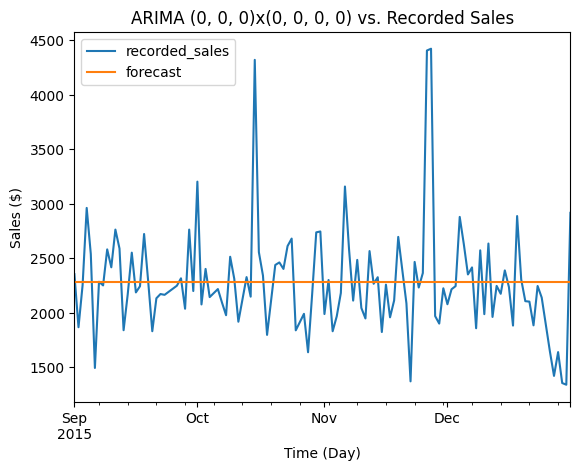

In [9]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test, predictions], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'ARIMA {model.order}x{model.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [10]:
# Create dictionary to store model orders and error metrics for comparison
scoring_dict = {}

# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.round(np.sqrt(mean_squared_error(test, predictions)), 2)
mae = np.round(mean_absolute_error(test, predictions), 2)

# View numerical performance
scoring_dict = {'Model 1' : [f'{model.order}x{model.seasonal_order}', {'scores': {'RMSE':rmse, 'MAE':mae}}]}
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}]}

Using all 0's for an ARIMA model is hardly using one at all. To do so says none of the previous values or previous error values are used in predicting the future values. The result is a horizontal line equal to the series's mean. This model captures none of the shape of the data, we most certainly can do better.

### Begin Fiddling with ARIMA model orders

In [11]:
# Create and fit the ARIMA model
model2 = ARIMA(endog=train, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), freq = 'D')
results2 = model2.fit()

In [12]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions2 = results2.predict(start = test.index[0], end = test.index[-1])
predictions2.sample(5)

2015-11-02    2282.123045
2015-09-21    2282.123045
2015-09-14    2282.123045
2015-10-11    2282.123045
2015-11-27    2282.123045
Name: predicted_mean, dtype: float64

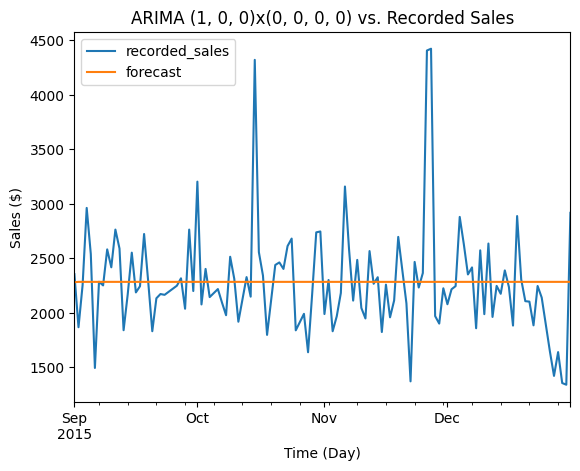

In [13]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast2 = pd.concat([test, predictions2], axis = 1) # Assemble test set and forecast into one dataframe
forecast2.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast2.plot()
plt.title(f'ARIMA {model2.order}x{model2.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [14]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse2 = np.round(np.sqrt(mean_squared_error(test, predictions2)), 2)
mae2 = np.round(mean_absolute_error(test, predictions2), 2)

# View numerical performance
scoring_dict['Model 2'] = [f'{model2.order}x{model2.seasonal_order}', {'scores': {'RMSE':rmse2, 'MAE':mae2}}]
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}],
 'Model 2': ['(1, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.24}}]}

### Another

In [15]:
# Create and fit the ARIMA model
model3 = ARIMA(endog=train, order=(0, 0, 1), seasonal_order=(0, 0, 0, 0), freq = 'D')
results3 = model3.fit()

In [16]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions3 = results3.predict(start = test.index[0], end = test.index[-1])
predictions3.sample(5)

2015-11-05    2282.123046
2015-12-25    2282.123046
2015-11-24    2282.123046
2015-10-27    2282.123046
2015-12-15    2282.123046
Name: predicted_mean, dtype: float64

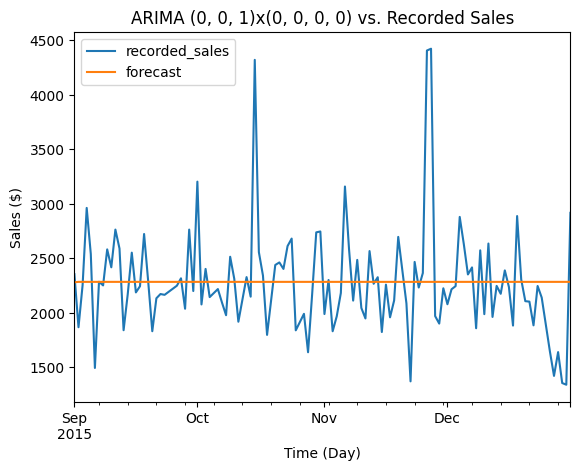

In [17]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast3 = pd.concat([test, predictions3], axis = 1) # Assemble test set and forecast into one dataframe
forecast3.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast3.plot()
plt.title(f'ARIMA {model3.order}x{model3.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [18]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse3 = np.round(np.sqrt(mean_squared_error(test, predictions3)), 2)
mae3 = np.round(mean_absolute_error(test, predictions3), 2)

# View numerical performance
scoring_dict['Model 3'] = [f'{model3.order}x{model3.seasonal_order}', {'scores': {'RMSE':rmse3, 'MAE':mae3}}]
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}],
 'Model 2': ['(1, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.24}}],
 'Model 3': ['(0, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.25}}]}

### Another

In [19]:
# Create and fit the ARIMA model
model4 = ARIMA(endog=train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0), freq = 'D')
results4 = model4.fit()

In [20]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions4 = results4.predict(start = test.index[0], end = test.index[-1])
predictions4.sample(5)

2015-10-28    2291.206960
2015-09-17    2325.250216
2015-12-09    2290.885913
2015-11-11    2290.949027
2015-11-25    2290.896578
Name: predicted_mean, dtype: float64

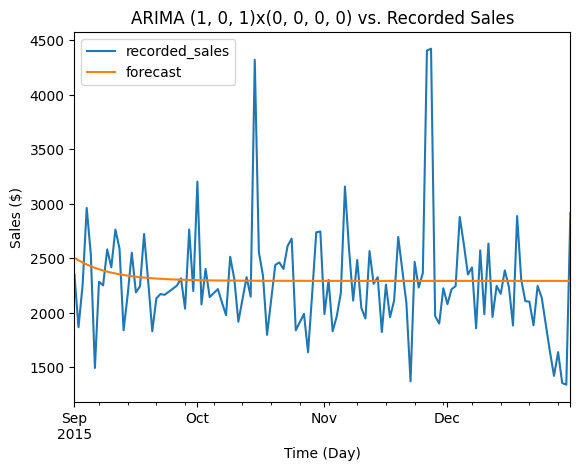

In [21]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast4 = pd.concat([test, predictions4], axis = 1) # Assemble test set and forecast into one dataframe
forecast4.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast4.plot()
plt.title(f'ARIMA {model4.order}x{model4.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [22]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse4 = np.round(np.sqrt(mean_squared_error(test, predictions4)), 2)
mae4 = np.round(mean_absolute_error(test, predictions4))

# View numerical performance
scoring_dict['Model 4'] = [f'{model4.order}x{model4.seasonal_order}', {'scores': {'RMSE':rmse4, 'MAE':mae4}}]
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}],
 'Model 2': ['(1, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.24}}],
 'Model 3': ['(0, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.25}}],
 'Model 4': ['(1, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 484.2, 'MAE': 324.0}}]}

### Another

In [23]:
# Create and fit the ARIMA model
model5 = ARIMA(endog=train, order=(0, 0, 0), seasonal_order=(1, 0, 0, 7), freq = 'D')
results5 = model5.fit()

In [24]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions5 = results5.predict(start = test.index[0], end = test.index[-1])
predictions5.sample(5)

2015-11-20    2282.126369
2015-09-20    2238.849565
2015-09-24    2278.687149
2015-10-01    2280.816792
2015-10-06    2281.147109
Name: predicted_mean, dtype: float64

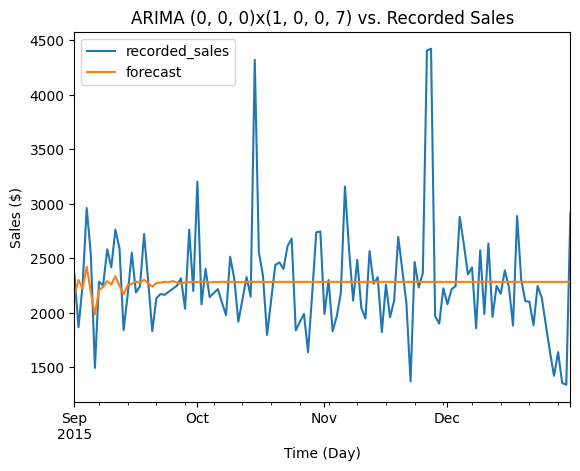

In [25]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast5 = pd.concat([test, predictions5], axis = 1) # Assemble test set and forecast into one dataframe
forecast5.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast5.plot()
plt.title(f'ARIMA {model5.order}x{model5.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [26]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse5 = np.round(np.sqrt(mean_squared_error(test, predictions5)), 2)
mae5 = np.round(mean_absolute_error(test, predictions5), 2)

# View numerical performance
scoring_dict['Model 5'] = [f'{model5.order}x{model5.seasonal_order}', {'scores': {'RMSE':rmse5, 'MAE':mae5}}]
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}],
 'Model 2': ['(1, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.24}}],
 'Model 3': ['(0, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.25}}],
 'Model 4': ['(1, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 484.2, 'MAE': 324.0}}],
 'Model 5': ['(0, 0, 0)x(1, 0, 0, 7)',
  {'scores': {'RMSE': 477.24, 'MAE': 315.48}}]}

Finally, including the seasonal orders starts to budge the root mean squared error.

### Another

In [27]:
# Create and fit the ARIMA model
model6 = ARIMA(endog=train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), freq = 'D')
results6 = model6.fit()

In [28]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions6 = results6.predict(start = test.index[0], end = test.index[-1])
predictions6.sample(5)

2015-12-25    2682.148990
2015-10-02    2694.135378
2015-11-02    2254.564076
2015-12-14    2253.048641
2015-09-06    1991.983662
Name: predicted_mean, dtype: float64

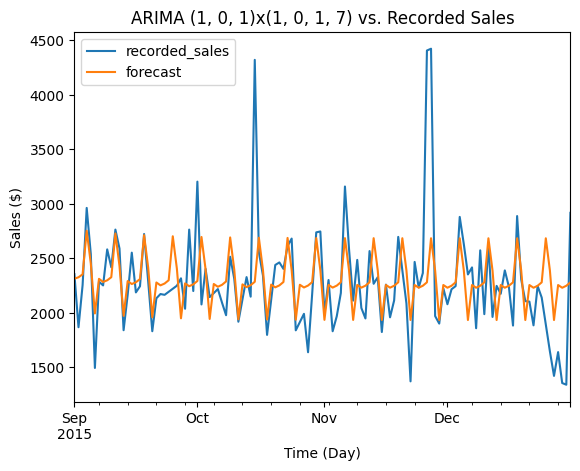

In [29]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast6 = pd.concat([test, predictions6], axis = 1) # Assemble test set and forecast into one dataframe
forecast6.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast6.plot()
plt.title(f'ARIMA {model6.order}x{model6.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [30]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse6 = np.round(np.sqrt(mean_squared_error(test, predictions6)), 2)
mae6 = np.round(mean_absolute_error(test, predictions6), 2)

# View numerical performance
scoring_dict['Model 6'] = [f'{model6.order}x{model6.seasonal_order}', {'scores': {'RMSE':rmse6, 'MAE':mae6}}]
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}],
 'Model 2': ['(1, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.24}}],
 'Model 3': ['(0, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.25}}],
 'Model 4': ['(1, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 484.2, 'MAE': 324.0}}],
 'Model 5': ['(0, 0, 0)x(1, 0, 0, 7)',
  {'scores': {'RMSE': 477.24, 'MAE': 315.48}}],
 'Model 6': ['(1, 0, 1)x(1, 0, 1, 7)',
  {'scores': {'RMSE': 432.99, 'MAE': 272.31}}]}

Including seasonal components as well as ARMA components makes a huge difference. From the plot you can see that the model has begun to approximate the test set much better than the previous iterations, which were mostly straight lines. Accordingly, the rmse dropped by about 40 dollars which has been by far the greatest decrease in error. As a side note, the mean absolute error is generally doing much better with these models. That is because our data has some pretty wild outliers and mae is more insulated against outliers. 

The above process of iteratively changing model orders and looking at performance is instructive, but not very efficient. Rather than manually iterate through every possible combination of model orders, within a reasonably constrained space, we will leverage an exhustive grid search style of order optimization. This will allow us to algorithmically determine the best model orders within the space we give it and with respect to rmse. As noted above, our eda has allowed us to narrow down on some model orders, reducing the amount of order combinations from the thousands to about one hundred. 

# Gridsearch To Algorithmically Determine Model Orders

In [31]:
# Function to test ARIMA parameter grid combinations
def SARIMA_grid(train, test, param_grid):
    scoring_df = pd.DataFrame()
    orders = []
    rootmse = []
    meanae = []
    
    for order in param_grid['order']:
        for seasonal_order in param_grid['seasonal_order']:
            try:
                model = ARIMA(endog=train, order = order, seasonal_order = seasonal_order, freq = 'D')
                results = model.fit()
            
                predictions = results.predict(start = test.index[0], end = test.index[-1])

                rmse = np.round(np.sqrt(mean_squared_error(test, predictions)), 2)
                mae = np.round(mean_absolute_error(test, predictions), 2)
                
                orders.append(f'{model.order}x{model.seasonal_order}')
                rootmse.append(rmse)
                meanae.append(mae)
                
            except:
                print('Error created with', order, seasonal_order)
                pass
    scoring_df['order'] = orders
    scoring_df['rmse'] = rootmse
    scoring_df['mae'] = meanae
    return scoring_df

In [32]:
param_grid = {
    'order': [(p, 0, q) for p in range(1, 3) for q in range(1, 3)],
    'seasonal_order': [(P, D, Q, 7) for P in range(1, 3) for D in range(0, 3) for Q in range(1, 3)]
}

gridsearch_df = SARIMA_grid(train, test, param_grid)

Error created with (2, 0, 2) (1, 0, 1, 7)


In [33]:
gridsearch_df.sort_values(by = 'rmse').head()

,order,rmse,mae
26,"(2, 0, 1)x(1, 1, 1, 7)",430.83,270.82
3,"(1, 0, 1)x(1, 1, 2, 7)",431.22,270.75
30,"(2, 0, 1)x(2, 0, 1, 7)",431.99,270.51
21,"(1, 0, 2)x(2, 1, 2, 7)",432.17,269.29
44,"(2, 0, 2)x(2, 1, 2, 7)",432.21,267.75


In [34]:
best_orders = (1, 0, 2)
best_seasonal_orders = (2, 1, 2, 7)

best_model = ARIMA(endog = train, order = best_orders, seasonal_order = best_seasonal_orders, freq='D')
best_results = best_model.fit()

best_predictions = best_results.predict(start = test.index[0], end = test.index[-1])

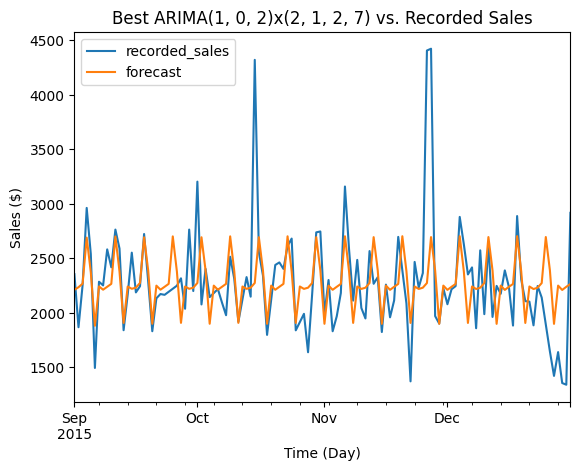

In [35]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test, best_predictions], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'Best ARIMA{best_model.order}x{best_model.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

# Test ARIMA Performance with Outlier Removal

As we have seen from the exploratory data analysis, our data has a small handful of days with extreme outliers. All of the test set/model plots above show some of these outliers, huge spikes in sales that the model didn't even come close to anticipating. One way of anticipating these outliers is through the addition of exogenous variables, which we will explore later. For now, we'd like to see what the model performance looks like when we just remove the outliers. 

In [36]:
# Calculate the 25th and 75th percentiles
Q1 = np.percentile(by_days, 25)
Q3 = np.percentile(by_days, 75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Calculate minimum and maximum thresholds for outliers
min_threshold = Q1 - (1.5 * IQR)
max_threshold = Q3 + (1.5 * IQR)
min_threshold, max_threshold

(1426.375, 3082.175)

In [37]:
# Filter out outliers. This will shorten the dataset. Need to add back in missing dates to get back to 365 days.
by_days_no_outliers = by_days[(by_days >= min_threshold) & (by_days <= max_threshold)]
len(by_days_no_outliers), len(by_days)

(349, 365)

In [38]:
# Reserve dates to create new date range with
min_date = by_days_no_outliers.index.min()
max_date = by_days_no_outliers.index.max()

In [39]:
# Isolate new date range and by_days_no_ouliers date range for comparison
complete_date_range = pd.date_range(min_date, max_date)
existing_dates = by_days_no_outliers.index

# Identify missing dates by comparing complete_date_range and existing_dates
missing_dates = complete_date_range.difference(existing_dates)

# Convert to list
missing_dates_list = missing_dates.tolist()
missing_dates_list

[Timestamp('2015-02-01 00:00:00'),
 Timestamp('2015-03-22 00:00:00'),
 Timestamp('2015-05-15 00:00:00'),
 Timestamp('2015-07-03 00:00:00'),
 Timestamp('2015-07-04 00:00:00'),
 Timestamp('2015-07-17 00:00:00'),
 Timestamp('2015-07-24 00:00:00'),
 Timestamp('2015-10-01 00:00:00'),
 Timestamp('2015-10-15 00:00:00'),
 Timestamp('2015-11-06 00:00:00'),
 Timestamp('2015-11-22 00:00:00'),
 Timestamp('2015-11-26 00:00:00'),
 Timestamp('2015-11-27 00:00:00'),
 Timestamp('2015-12-27 00:00:00'),
 Timestamp('2015-12-29 00:00:00'),
 Timestamp('2015-12-30 00:00:00')]

In [40]:
# Create a new entry (nan) in by_days_no_outliers for each of the dates it is missing
for missing_date in missing_dates:
    by_days_no_outliers[missing_date] = np.nan

# Sort, just in case
by_days_no_outliers.sort_index(inplace=True)

# Interpolate missing values using simple averaging of neighboring days
by_days_no_outliers.interpolate(method='time', inplace=True)

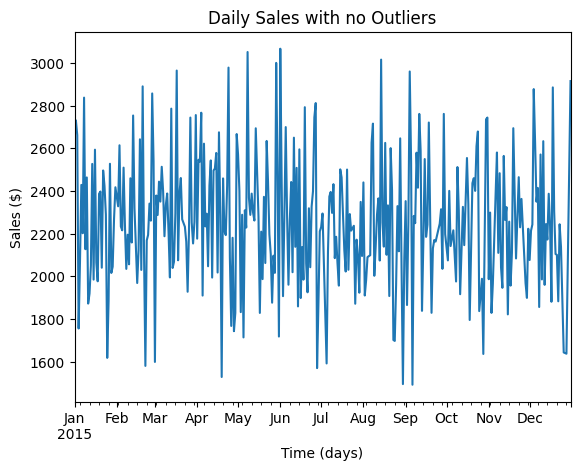

In [41]:
# Take a look at newly interpolated daily sales with outliers removed
by_days_no_outliers.plot()
plt.title('Daily Sales with no Outliers')
plt.xlabel('Time (days)')
plt.ylabel('Sales ($)')
plt.show()

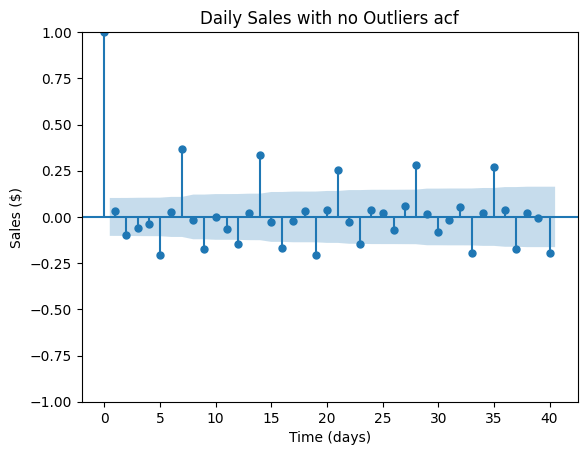

In [42]:
plot_acf(by_days_no_outliers, lags = 40)
plt.title('Daily Sales with no Outliers acf')
plt.xlabel('Time (days)')
plt.ylabel('Sales ($)')
plt.show()

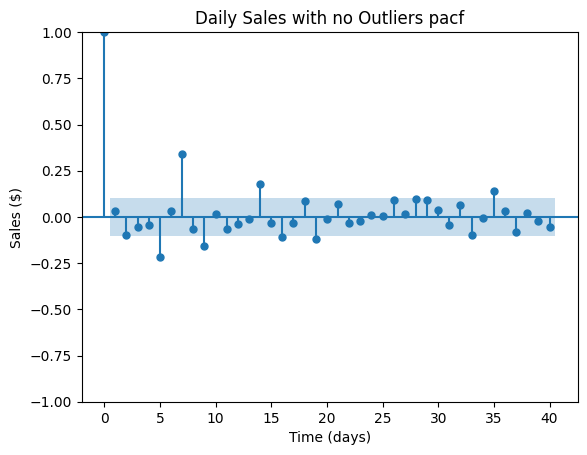

In [43]:
plot_pacf(by_days_no_outliers, lags = 40)
plt.title('Daily Sales with no Outliers pacf')
plt.xlabel('Time (days)')
plt.ylabel('Sales ($)')
plt.show()

In [44]:
# Redefine train/test from by_days_no_outliers, since original train/test were from by_days
train_no_outliers = by_days_no_outliers.loc[:'2015-08-31']
test_no_outliers = by_days_no_outliers.loc['2015-09-01':]

# Run grid search function again with outlier free train and test data
gridsearch_df_no_outliers = SARIMA_grid(train_no_outliers, test_no_outliers, param_grid)

gridsearch_df_no_outliers.sort_values(by = 'rmse').head()

Error created with (1, 0, 1) (2, 1, 2, 7)
Error created with (2, 0, 1) (2, 0, 2, 7)
Error created with (2, 0, 1) (2, 1, 2, 7)
Error created with (2, 0, 2) (2, 0, 2, 7)
Error created with (2, 0, 2) (2, 1, 1, 7)


,order,rmse,mae
17,"(1, 0, 2)x(2, 0, 1, 7)",255.93,199.76
7,"(1, 0, 1)x(2, 0, 2, 7)",255.98,199.53
39,"(2, 0, 2)x(2, 0, 1, 7)",256.29,201.42
29,"(2, 0, 1)x(2, 0, 1, 7)",256.32,201.88
24,"(2, 0, 1)x(1, 0, 2, 7)",256.35,201.84


In [45]:
gridsearch_df['rmse'].sort_values()[0]

432.99

In [46]:
gridsearch_df['rmse'].sort_values()[0] - gridsearch_df_no_outliers['rmse'].sort_values()[0]

175.28000000000003

About 170 dollars better root mean squared error! Below we visually see how much of a better fit the model can produce on data without outliers.

In [49]:
best_model_no_outliers = ARIMA(endog = train_no_outliers, order=(1, 0, 2), seasonal_order=(2, 0, 1, 7), freq='D')
best_results_no_outliers = best_model_no_outliers.fit()
best_predictions_no_outliers = best_results_no_outliers.predict(start = test_no_outliers.index[0], end = test_no_outliers.index[-1])

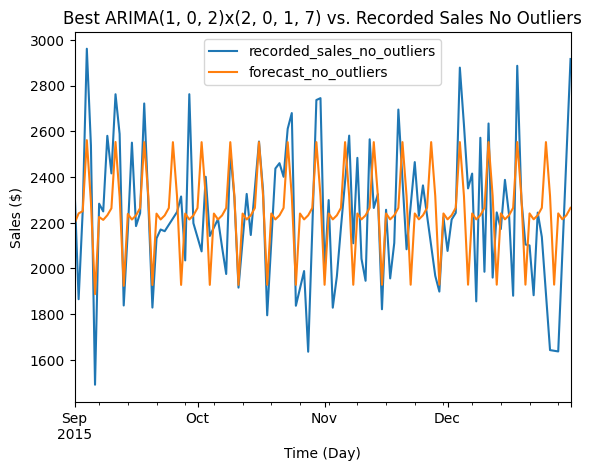

In [50]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test_no_outliers, best_predictions_no_outliers], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales_no_outliers', 'predicted_mean': 'forecast_no_outliers'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'Best ARIMA{best_model_no_outliers.order}x{best_model_no_outliers.seasonal_order} vs. Recorded Sales No Outliers')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

# Baseline Comparison
Your model's performance means only so much on its own. Often we find ourselves needing to know how well our model has done *compared to* the current model, or compared to some baseline. Here we explore different baselines and see what their error metrics are like.

To begin with, we'll test against a seasonal naive forecast that simply predicts next week's sales will be exactly the same as last week's sales.

In [51]:
# Generate Seasonal Naive Forecast
seasonal_naive_forecast = test_no_outliers.shift(7)

# Remove NaN values produced by the shift operation
seasonal_naive_forecast.rename('seasonal_naive_forecast2', inplace = True).dropna(inplace=True)

# Compute error metrics for seasonal naive forecast against original test set (without outliers)
naive_rmse = np.sqrt(mean_squared_error(test_no_outliers[7:], seasonal_naive_forecast))
naive_mae = mean_absolute_error(test_no_outliers[7:], seasonal_naive_forecast)
print(f'Naive Forecast RMSE (without outliers): {naive_rmse}')
print(f'Naive Forecast MAE (without outliers): {naive_mae}')

Naive Forecast RMSE (without outliers): 319.78530846344074
Naive Forecast MAE (without outliers): 248.8354347826087


319.79 RMSE without outliers. Not bad, only about $70 dollars worse than the ARIMA model.

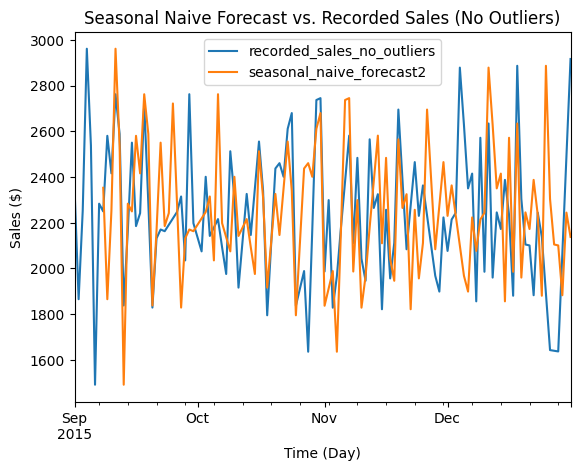

In [52]:
# Visually inspect naive forecase against test set
forecast = pd.concat([test_no_outliers, seasonal_naive_forecast], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales_no_outliers'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'Seasonal Naive Forecast vs. Recorded Sales (No Outliers)')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

Next we try to introduce some noise to the naive seasonal forecase to try and better simulate the unpredictability of actual sales. This new more sophisticated yet still naive model will serve as another point of comparison.

In [53]:
# Store array of noise variable: random numbers with equal chance to be chosen +/- one standard deviation of the daily sales
noise = np.random.uniform(-test_no_outliers.std(), test_no_outliers.std(), size = len(seasonal_naive_forecast))

# Add noise onto the naive seasonal forecast
noisy_seasonal_naive_forecast = seasonal_naive_forecast + noise

# Calculate error
noisy_naive_rmse = np.sqrt(mean_squared_error(test_no_outliers[7:], noisy_seasonal_naive_forecast))
noisy_naive_mae = np.sqrt(mean_absolute_error(test_no_outliers[7:], noisy_seasonal_naive_forecast))
print(f'Noisy Naive Forecast RMSE (without outliers): {noisy_naive_rmse}')
print(f'Noisy Naive Forecast MAE (without outliers): {noisy_naive_mae}')

Noisy Naive Forecast RMSE (without outliers): 364.54757003097757
Noisy Naive Forecast MAE (without outliers): 17.005809555283854


In [54]:
naive_rmse - noisy_naive_rmse

-44.762261567536825

Adding in the noise makes the naive model perform worse.

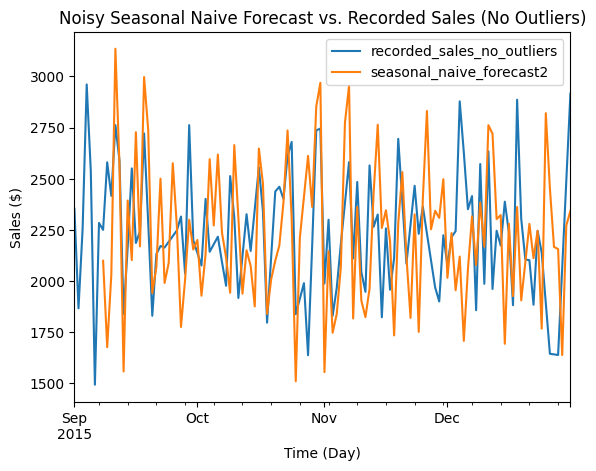

In [55]:
# Visually inspect noisy naive forecast against test set
forecast = pd.concat([test_no_outliers, noisy_seasonal_naive_forecast], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales_no_outliers'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'Noisy Seasonal Naive Forecast vs. Recorded Sales (No Outliers)')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

# Incorporate Exogenous Variables to ARIMAX Model

In [64]:
columns_to_use = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'DATE', 'TMAX', 'TMIN', 'PRCP']
exog_df = pd.read_pickle('data/exogenous_variables.pkl')
exog_df.head()

,STATION,NAME,LATITUDE,LONGITUDE,DATE,PRCP,TMAX,TMIN
5251,USC00283704,"HARRISON, NJ US",40.7481,-74.152,2015-01-01,0.0,0.0,-5.0
5252,USC00283704,"HARRISON, NJ US",40.7481,-74.152,2015-01-02,0.0,3.3,-5.0
5253,USC00283704,"HARRISON, NJ US",40.7481,-74.152,2015-01-03,0.0,6.1,-1.7
5254,USC00283704,"HARRISON, NJ US",40.7481,-74.152,2015-01-04,27.4,5.6,0.0
5255,USC00283704,"HARRISON, NJ US",40.7481,-74.152,2015-01-05,3.0,12.2,4.4


In [65]:
precip = exog_df[['PRCP']]
precip = precip.head(-1)

In [66]:
by_days.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', name='order_date', length=365, freq=None)

In [71]:
precip.set_index(by_days_no_outliers.index, inplace = True)
precip.head()

,PRCP
order_date,
2015-01-01,0.0
2015-01-02,0.0
2015-01-03,0.0
2015-01-04,27.4
2015-01-05,3.0


In [72]:
model = ARIMA(by_days_no_outliers, exog=precip, order=(1, 0, 2), seasonal_order=(1, 0, 2, 7))
results = model.fit()
predictions = results.predict(start = test.index[0], end = test.index[-1])

In [73]:
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}],
 'Model 2': ['(1, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.24}}],
 'Model 3': ['(0, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.25}}],
 'Model 4': ['(1, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 484.2, 'MAE': 324.0}}],
 'Model 5': ['(0, 0, 0)x(1, 0, 0, 7)',
  {'scores': {'RMSE': 477.24, 'MAE': 315.48}}],
 'Model 6': ['(1, 0, 1)x(1, 0, 1, 7)',
  {'scores': {'RMSE': 432.99, 'MAE': 272.31}}]}

In [70]:
rmse_no_outliers 

NameError: name 'rmse_no_outliers' is not defined

In [74]:
rmse_tuned

NameError: name 'rmse_tuned' is not defined

In [75]:
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
rmse, mae

(432.2403771953717, 269.00610247885515)

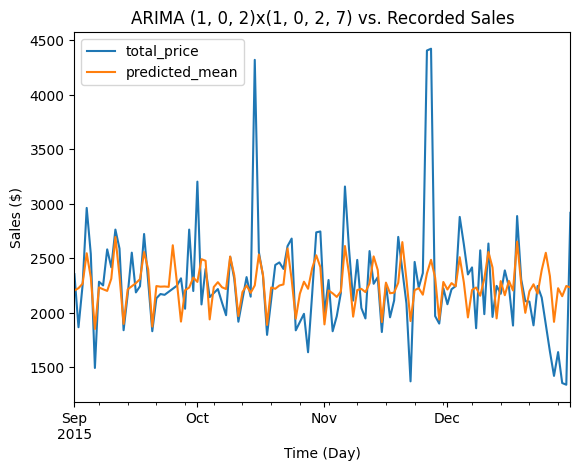

In [76]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test, predictions], axis = 1) # Assemble test set and forecast into one dataframe
# forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'ARIMA {model.order}x{model.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [77]:
trainx = precip.loc[:'2015-08-31']
testx = precip.loc['2015-09-01':]

In [ ]:
# Function to test ARIMA parameter grid combinations
def SARIMAX_grid(train, test, param_grid, test_exog, train_exog):
    scoring_df = pd.DataFrame()
    orders = []
    rootmse = []
    meanae = []
    
    for order in param_grid['order']:
        for seasonal_order in param_grid['seasonal_order']:
            try:
                model = ARIMA(endog=train, exog=trainx order = order, seasonal_order = seasonal_order, freq = 'D')
                results = model.fit()
            
                predictions = results.predict(start = test.index[0], end = test.index[-1], exog=test_exog)

                rmse = np.round(np.sqrt(mean_squared_error(test, predictions)), 2)
                mae = np.round(mean_absolute_error(test, predictions), 2)
                
                orders.append(f'{model.order}x{model.seasonal_order}')
                rootmse.append(rmse)
                meanae.append(mae)
                
            except:
                print('Error created with', order, seasonal_order)
                pass

    scoring_df['order'] = orders
    scoring_df['rmse'] = rootmse
    scoring_df['mae'] = meanae
    return scoring_df

In [ ]:
exogenous_score_dict = SARIMAX_grid(train, test, param_grid, trainx, testx ):

In [79]:


# Initialize the GridSearchCV
grid = GridSearchCV(estimator=ARIMAXWrapper(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=[(slice(None), slice(None))], verbose=2, n_jobs=-1)

# Fit to the data
grid.fit(train.index, train, exog = trainx)

# Summary of the best model
print(f'Best ARIMA{grid.best_params_["order"]}x{grid.best_params_["seasonal_order"]} model - MSE:{-grid.best_score_}')

# Predicting and calculating MSE
y_pred = grid.best_estimator_.predict(test, exog = testx)
mae_tuned = mean_absolute_error(test, y_pred)
rmse_tuned = sqrt(mean_squared_error(test, y_pred))

print(f'Mean Absolute Error (MAE): {mae_tuned}')
print(f'Root Mean Squared Error (RMSE): {rmse_tuned}')

NameError: name 'GridSearchCV' is not defined

# Freeze all packages and their versions

In [ ]:
# %pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
